In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
plt.style.use('science')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = (5,9)
plt.rcParams['figure.figsize'] = 8,6

In [4]:
import statistics as sts
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.cluster import KMeans

In [6]:
from separate_class import Separate

In [7]:
ds2_train = pd.read_csv("train2.csv", header = None)

In [8]:
ds2_test = pd.read_csv("dev2.csv", header = None)

In [5]:
ds2_train.head()

,0,1,2
0,0.537115,0.452538,0.0
1,0.380729,0.371252,0.0
2,0.551707,0.496879,0.0
3,0.128153,0.337706,0.0
4,-0.893600,-2.493547,0.0


In [6]:
ds2_test.head()

,0,1,2
0,0.438052,-2.337230,0.0
1,1.229295,0.295078,0.0
2,1.586945,-0.242402,0.0
3,-1.047739,-2.606678,0.0
4,0.993552,0.350345,0.0


In [7]:
ds2_train.describe()

,0,1,2
count,600.000000,600.000000,600.000000
mean,-0.042402,-0.091633,1.000000
std,1.233388,1.210003,0.817178
min,-2.616755,-2.691837,0.000000
25%,-0.759021,-0.913126,0.000000
50%,0.023447,-0.027872,1.000000
75%,0.722100,0.533472,2.000000
max,2.962532,2.914333,2.000000


In [8]:
ds2_test.describe()

,0,1,2
count,90.000000,90.000000,90.000000
mean,0.035789,-0.059239,1.000000
std,1.400120,1.282555,0.821071
min,-2.664174,-2.743262,0.000000
25%,-0.904883,-1.027395,0.000000
50%,0.123987,-0.039386,1.000000
75%,1.030963,0.842043,2.000000
max,2.948352,2.626817,2.000000


In [8]:
X_train = ds2_train.iloc[:,:2]
Y_train = ds2_train.iloc[:,2]

In [9]:
def gaus(x,m,c,d):
    return((1/(((2*np.pi)**(d/2))*np.sqrt(np.linalg.det(c))))*np.exp(-(x-m).T@np.linalg.inv(c)@(x-m)/2))

In [10]:
sep_train = Separate(ds2_train)

In [12]:
X_sep_train = sep_train.get_x()
Y_sep_train = sep_train.get_y()
dat_sep_train = sep_train.get_separated_data()

In [14]:
pd.DataFrame(X_sep_train[0]).to_csv("X_sep_train.csv")

In [13]:
def likelihood(x,m,W,c):
    s = 0
    m = np.array(m)
    l = len(W)
    for i in range(l):
        s += W[i]*gaus(x,m[i],c[i],d)
    return(s)

In [14]:
import time

In [15]:
from multiprocessing import Pool

In [30]:
class_ = 2
d = 2
threshold = 0.01

In [31]:
# parameter estimation for Bayesian GMM - EM method
# training and obtaining parameters for different hperparameter values


#for Q in q:
def f(Q):
    L_old = 0
    L_new = 1
    L = []
    difference = L_new - L_old
    cond = True
    # inititalization
    while (cond==True):
        kmeans = KMeans(n_clusters = Q, random_state = 0).fit(X_sep_train[class_])
        labels = kmeans.labels_
        N = np.array([])
        for i in range(Q):
            N = np.append(N,np.count_nonzero(labels==i))
        cond = True in (ele ==1 for ele in N)

    Nt = np.sum(N)
    w = N/Nt
    gamma = []
    for i in range(Q):
        gamma.append(np.multiply(labels==i,1))
    mu = kmeans.cluster_centers_
    n = len(X_sep_train[0])
    C = np.zeros((Q,d,d))
    for i in range(Q):
        for j in range(n):
            C[i] += gamma[i][j]*np.outer(X_sep_train[class_].iloc[j] - mu[i],X_sep_train[class_].iloc[j] - mu[i])
        C[i] = np.diag(np.diag(C[i]/N[i]))

    L_old = 0
    for i in range(n):
        L_old += np.log(likelihood(X_sep_train[class_].iloc[i],mu,w,C))
    
    while (difference > threshold):
        

        #Expectation
        den = np.zeros(n)
        for i in range(n):
            for j in range(Q):
                den[i] += w[j]*gaus(X_sep_train[class_].iloc[i],np.array(mu)[j],C[j],d)

        gamma = np.zeros((Q,n))
        for i in range(n):
            for j in range(Q):
                gamma[j][i] = w[j]*gaus(X_sep_train[class_].iloc[i], np.array(mu)[j], C[j],d)/den[i]

        # maximization step
        N = []
        for i in range(Q):
            N.append(np.sum(gamma[i]))
        Nt = np.sum(N)
        w = N/Nt
        mu = np.divide(gamma@X_sep_train[class_],np.array([N,N]).T)
        C = np.zeros((Q,d,d))
        for i in range(Q):
            for j in range(n):
                C[i] += gamma[i][j]*np.outer(X_sep_train[class_].iloc[j] - mu.iloc[i],X_sep_train[class_].iloc[j] - mu.iloc[i])
            C[i] = np.diag(np.diag(C[i]/N[i]))

        L_new = 0
        for i in range(n):
            L_new += np.log(likelihood(X_sep_train[class_].iloc[i],mu.to_numpy(),w,C))
        #print(L_new,L_old)
        difference = L_new - L_old
        L_old = L_new
        L.append(L_new)
    return([mu,w,C,L])
    #L_q.append(L)
    #add accuracy and confusion matrix

In [32]:
pool = Pool(processes=4)

In [19]:
q = list(range(2,10))

In [33]:
t1 = time.time()
params = pool.map(f,q)
t2 = time.time()

In [21]:
dbfile = open("class2_1b",'ab')
pickle.dump(class_2_param,dbfile)
dbfile.close()

In [18]:
dbfile = open("class0_1b",'rb')
class_0_param = pickle.load(dbfile)
dbfile.close()

In [ ]:
dbfile = open("class1_1b",'rb')
class_1_param = pickle.load(dbfile)
dbfile.close()

In [ ]:
dbfile = open("class2_1b",'rb')
class_2_param = pickle.load(dbfile)
dbfile.close()

In [86]:
class_val = 2
idx = 2
q_val = 1

In [91]:
print(likelihood(X_sep_train[class_val].iloc[idx],class_0_param[q_val][0],class_0_param[q_val][1],class_0_param[q_val][2]))
print(likelihood(X_sep_train[class_val].iloc[idx],class_1_param[q_val][0],class_1_param[q_val][1],class_1_param[q_val][2]))
print(likelihood(X_sep_train[class_val].iloc[idx],class_2_param[q_val][0],class_2_param[q_val][1],class_2_param[q_val][2]))

5.7590949254497044e-05
0.0007146275862570975
0.14380201738510068


In [96]:
parameters = [class_0_param,class_1_param, class_2_param]

In [104]:
featvec_length = sep_train.feat_length

In [129]:
import accuracy

In [151]:
#predicting training data - selecting max likelihood value

acc_train = []
for Q in range(len(q)):
    y_Pred = []
    for i in range(600):
        lst = []
        for j in range(featvec_length+1):
            lst.append(likelihood(X_train.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
        y_Pred.append(lst.index(max(lst)))
        #print(y_Pred[i])
    acc_calc = accuracy.Confusion_matrix(y_Pred,Y_train)
    acc_train.append(acc_calc.accuracy)


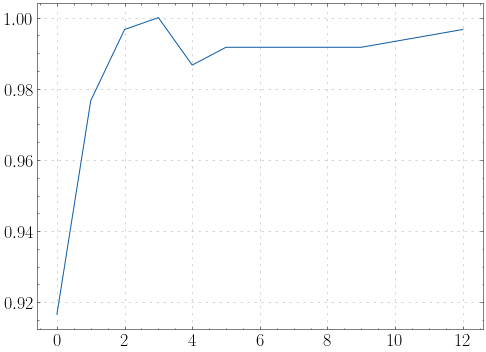

In [153]:
plt.plot(acc_train)

In [160]:
ds2_test = pd.read_csv("dev2.csv", header = None)

In [164]:
X_cv,X_test,y_cv,y_test = train_test_split(ds2_test.iloc[:,:2],ds2_test.iloc[:,2], test_size=0.3, random_state=0)

In [169]:
acc_cv = []
for Q in range(len(q)):
    y_Pred = []
    for i in range(len(X_cv)):
        lst = []
        for j in range(featvec_length+1):
            lst.append(likelihood(X_cv.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
        y_Pred.append(lst.index(max(lst)))
        #print(y_Pred[i])
    acc_calc = accuracy.Confusion_matrix(y_Pred,y_cv)
    acc_cv.append(acc_calc.accuracy)


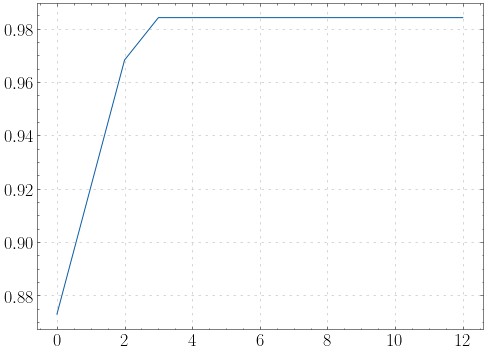

In [170]:
plt.plot(acc_cv)

In [173]:
acc_cv.index(max(acc_cv))

3

In [174]:
q[3]

5

In [176]:
acc_train.index(max(acc_train))

3

In [178]:
# best model, q = 5
Q = 3
y_Pred = []
for i in range(len(X_test)):
    lst = []
    for j in range(featvec_length+1):
        lst.append(likelihood(X_test.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    y_Pred.append(lst.index(max(lst)))
    #print(y_Pred[i])
acc_calc = accuracy.Confusion_matrix(y_Pred,y_test)
acc_test = acc_calc.accuracy


In [204]:
YPredTrain = []
for i in range(len(X_train)):
    lst = []
    for j in range(featvec_length+1):
        lst.append(likelihood(X_train.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredTrain.append(lst.index(max(lst)))

In [207]:
YPredCV = []
for i in range(len(X_cv)):
    lst = []
    for j in range(featvec_length+1):
        lst.append(likelihood(X_cv.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredCV.append(lst.index(max(lst)))
    
YPredTest = []
for i in range(len(X_test)):
    lst = []
    for j in range(featvec_length+1):
        lst.append(likelihood(X_test.iloc[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    YPredTest.append(lst.index(max(lst)))

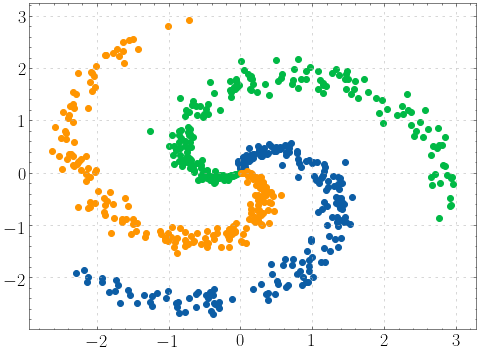

In [194]:
for class_val in range(3):
    row_idx = np.where(ds2_train.iloc[:,featvec_length]==class_val)
    plt.scatter(np.array(ds2_train)[row_idx,0],np.array(ds2_train)[row_idx,1])
plt.show()

In [214]:
min_x1 = min(X_train[0])
max_x1 = max(X_train[0])
min_x2 = min(X_train[1])
max_x2 = max(X_train[1])

x1_range = np.linspace(min_x1,max_x1)
x2_range = np.linspace(min_x2,max_x2)

X1,X2 = np.meshgrid(x1_range,x2_range)

x1,x2 = X1.flatten(),X2.flatten()
x1,x2 = x1.reshape(len(x1),1),x2.reshape(len(x2),1)
grid = np.hstack((x1,x2))

In [217]:
yGridPred = []
for i in range(len(grid)):
    lst = []
    for j in range(3):
        lst.append(likelihood(grid[i],parameters[j][Q][0],parameters[j][Q][1],parameters[j][Q][2]))
    yGridPred.append(lst.index(max(lst)))
yGridPred = np.array(yGridPred).reshape(X1.shape)

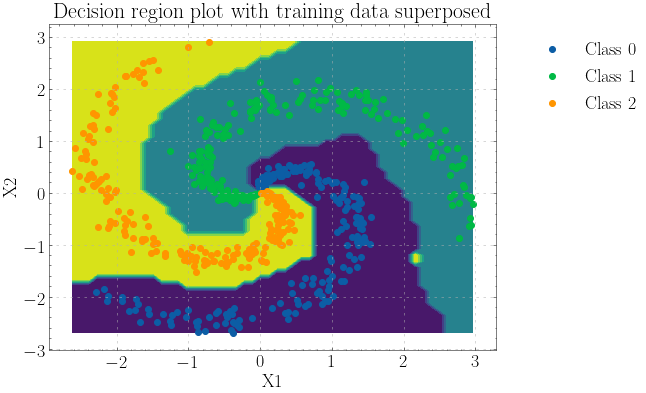

In [225]:
plt.contourf(X1,X2,yGridPred)
for class_val in range(3):
    row_idx = np.where(ds2_train.iloc[:,featvec_length]==class_val)
    plt.scatter(np.array(ds2_train)[row_idx,0],np.array(ds2_train)[row_idx,1],label = "Class "+ str(class_val))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision region plot with training data superposed")
plt.savefig("decisionReg_ds2.png")
plt.show()

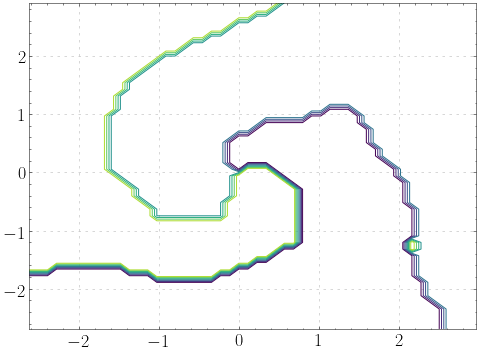

In [226]:
plt.contour(X1,X2,yGridPred)